In [11]:
%matplotlib notebook

[Table of Contents](table_of_contents.ipynb)

# Appendix A. Common Attitude Representations

[Introduction](#Introduction)

## Introduction

A point in 3D space can be thought of as a vector pointing from the origin to the point. This vector, when described in a frame of reference, is fully parameterized by three scalars. Being a vector, it inherits all of the beneficial mathematical properties of a vector space, including associativity and commutativity of addition, the identity and inverse elements, and scalar multiplication.

Attitude, on the other hand, is not so elegant. While it is true, that there are only three degrees of freedom to describe orientation, none of the representation methods form a global, minimum representation. Some behave like vector spaces, but are only local charts (e.g. Euler anges, Rodriguez) and others are global but are embedded in a higher dimensional space (e.g. rotation matrices, unit quaternions).

Here we will explore some of the most common methods for representing attitude and touch on their pros and cons. Much of this material is based on Shuster's work in
 * Shuster, M. D. (1993). A Survey of attitude representations. The Journal of the Astronautical Sciences, 1(4), 439–517.

## The $SO(3)$ Manifold

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits import mplot3d

class Attitude:
    # This class will be used to convert between the many methods of representing attitude.
    # The base internal representation will be a rotation matrix, as it has the fewest
    # caveats and conversion to and from the rotation matrix is well understood.
    def __init__(self, R=np.eye(3)):
        self.R = R
        self.init_visualization()
        self._interact_options = {}
    
    @staticmethod
    def identity():
        return Attitude()
    
    def set_rotation_matrix(self, R):
        self.R = R
        self.update_vis()
        
    def init_visualization(self):
        # load and draw the plane
        self._plane = pickle.load(open("files/T38.p", "rb"))
        self._figure = plt.figure()
#         self._axes = plt.subplot2grid((6, 1), (0, 0), rowspan=5, projection='3d')
        self._axes = mplot3d.Axes3D(self._figure)
        self._axes.set_aspect('equal')
        scale = self._plane.points/np.max(self._plane.points).flatten('F')
        self._base_R = np.array([[0, 0, 1],
                                 [1, 0, 0],
                                 [0, -1, 0]])
        R = self.R.T.dot(self._base_R)
        vectors = np.einsum('ij,...j->...i', R, self._plane.vectors)/np.max(self._plane.points)
        self._faces = mplot3d.art3d.Poly3DCollection(vectors)
        self._faces.set_facecolor((0,0,1))
        self._faces.set_edgecolor((0.3, 0.3, 0.6))
        self._axes.add_collection3d(self._faces)
#         self._axes.auto_scale_xyz(scale, scale, scale)
        print(scale.shape)
        # Create cubic bounding box to simulate equal aspect ratio (this is a workaround)
        max_range = 2
        Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten()
        Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten()
        Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten()
        # Comment or uncomment following both lines to test the fake bounding box:
        for xb, yb, zb in zip(Xb, Yb, Zb):
           self._axes.plot([xb], [yb], [zb], 'w')
        self._axes.set_xlabel('North')
        self._axes.set_ylabel('East')
        self._axes.set_zlabel('Down')
        self._axes.invert_yaxis()
        self._axes.invert_zaxis()
        
        # draw the inertial frame
        self._axes.quiver([0,0,0],[0,0,0],[0,0,0],#[-1,-1,-1],[1,1,1],[1,1,1],
                    [1,0,0],[0,1,0],[0,0,1], 
                    colors=['r','g','b','r','r','g','g','b','b'], pivot='tail')
        

    
        
    def update_vis(self):
        R = self.R.T.dot(self._base_R)
        vectors = np.einsum('ij,...j->...i', R, self._plane.vectors)/np.max(self._plane.points)
        self._faces.set_verts(vectors)
        self._figure.canvas.draw_idle()
    

    
    def show(self):
        self._figure.show()
        
        

## Rotation Matrices

## Euler Angles

In [57]:
from ipywidgets import interactive, Button, HBox, VBox
import ipywidgets as widgets
from IPython.display import display

class Attitude(Attitude):
    def __init__(self, R=np.eye(3)):
        super().__init__(R)
        self._interact_options['euler'] = self.interact_euler
        
    def set_euler_angles(self, phi, theta, psi, order='321'):
        # Note: these are passive notations
        c = np.cos
        s = np.sin
        rot_1 = lambda x: np.array([[1,     0,    0],
                                    [0,  c(x), s(x)],
                                    [0, -s(x), c(x)]])
        rot_2 = lambda x: np.array([[c(x), 0, -s(x)],
                                    [   0, 1,     0],
                                    [s(x), 0,  c(x)]])
        rot_3 = lambda x: np.array([[ c(x), s(x), 0],
                                    [-s(x), c(x), 0],
                                    [   0,     0, 1]])
        rots = {"1":rot_1, "2":rot_2, "3":rot_3}
        order = list(order)
        R = np.eye(3)
        R = rots[order[0]](psi).dot(R)
        R = rots[order[1]](theta).dot(R)
        R = rots[order[2]](phi).dot(R)
        self.set_rotation_matrix(R)
        
    def euler_slider_update(self, yaw, pitch, roll):
#         yaw = self._yaw_slider.val
        self.set_euler_angles(roll, pitch, yaw)
    
    def reset_yaw(self, b):
        self._sliders.children[0].value = 0.0
    def reset_pitch(self, b):
        self._sliders.children[1].value = 0.0
    def reset_roll(self, b):
        self._sliders.children[2].value = 0.0
    def reset_all(self, b):
        self.reset
        
    def interact_euler(self):
        self._sliders = interactive(self.euler_slider_update, 
                                    yaw=(-np.pi, np.pi), 
                                    pitch=(-np.pi/2, np.pi/2), 
                                    roll=(-np.pi, np.pi))
        reset_yaw = Button(description="reset")
        reset_pitch = Button(description="reset")
        reset_roll = Button(description="reset")
        
        reset_yaw.on_click(self.reset_yaw)
        reset_pitch.on_click(self.reset_pitch)
        reset_roll.on_click(self.reset_roll)
        
        reset_buttons = VBox([reset_yaw, reset_pitch, reset_roll])
        # display(self._sliders)
        euler_controls = HBox([self._sliders, reset_buttons])
        
        reset_all = Button(description="reset all")
        reset_all.on_click(self.reset_all)
        controls = VBox([euler_controls, reset_all])
        display(controls)
        
    def show(self, style=None):
        super().show()
        if style is not None:
            self._interact_options[style]()

<IPython.core.display.Javascript object>


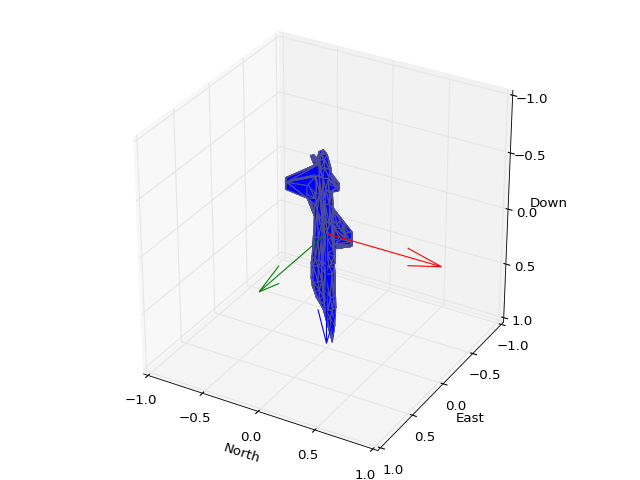

(1000, 9)


In [58]:
att = Attitude()
att.show('euler')

## Axis-Azimuth

## Unit Quaternion

The unit quaternion, sometimes called *Euler-Rodrigues symmetric parameters*, *Euler symmetric parameters*, or the *quaternion of rotation*, is a four-dimensional representation of attitude.

We shall represent quaternions using the Hamiltonian Notation as
$$
\mathbf{q} = q_w + q_x i + q_y j + q_z k = \begin{bmatrix}q_w & \bar{\mathbf{q}} \end{bmatrix}^\top
$$
where $q_w$ is commonly called the *scalar part* and $\bar{\mathbf{q}}$ the *vector part* of the quaternion. For the quaternion to represent an attitude, we must enforce the constraint that the quaternion be of unit norm, i.e

$$
\|\mathbf{q}\| = 1
$$

Here is a reasonable treatment of the difference between the [Hamiltonian and JPL conventions](https://fzheng.me/2017/11/12/quaternion_conventions_en/). Note that Shuster uses the JPL convention.

The set of all quaternions, $\mathbb{H}$, is analagous to the complex numbers, $\mathbb{C}$, where

$$
i^2 = j^2 = k^2 = ijk = -1.
$$

While unit quaternions do not suffer from a singularity, they are a double cover of $SO(3)$, where $\mathbf{q}$ and $-\mathbf{q}$ correspond to the same attitude.

Unit quaternions form a Lie group, with operator
$$
\mathbf{r} = \mathbf{p} \otimes \mathbf{q} = \begin{bmatrix}p_{w} & -\bar{\boldsymbol{p}}^{\top}\\
\bar{\boldsymbol{p}} & p_{w}{\bf I}+\left\lfloor \bar{\boldsymbol{p}}\right\rfloor 
\end{bmatrix}\begin{bmatrix}q_{w}\\
\bar{\boldsymbol{q}}
\end{bmatrix}
$$

A \[possibly helpful\] visualization of unit quaternions is found at https://quaternions.online/.